In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
from nltk.corpus import stopwords

import re
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Data/train.csv')

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
new_df = df.sample(50000, random_state=2)

In [5]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 398782 to 226665
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            50000 non-null  int64 
 1   qid1          50000 non-null  int64 
 2   qid2          50000 non-null  int64 
 3   question1     50000 non-null  object
 4   question2     50000 non-null  object
 5   is_duplicate  50000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 2.7+ MB


In [6]:
new_df.duplicated().sum()

0

In [7]:
# how many 1 and 0
new_df.is_duplicate.value_counts()

is_duplicate
0    31601
1    18399
Name: count, dtype: int64

<BarContainer object of 2 artists>

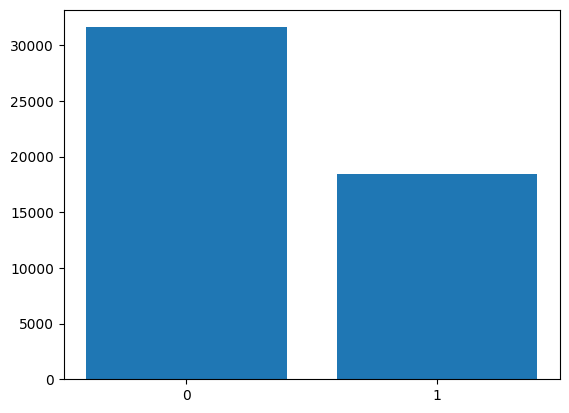

In [8]:
plt.bar(['0','1'], new_df['is_duplicate'].value_counts())

In [9]:
# Repeated questions
qid = pd.Series(new_df['qid1'].tolist() + new_df['qid2'].tolist())
print('Number of unique questions',np.unique(qid).shape[0])
x = qid.value_counts()>1
print('Number of questions getting repeated',x[x].shape[0])

Number of unique questions 88945
Number of questions getting repeated 7384


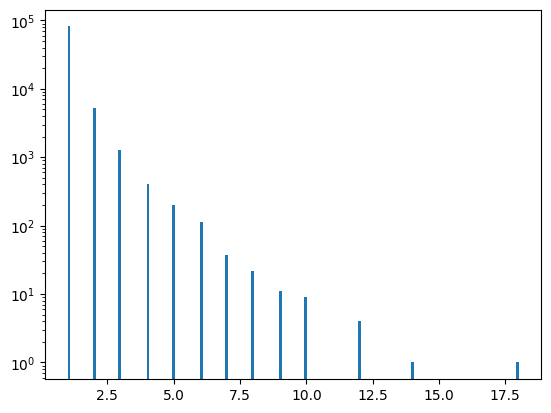

In [10]:
plt.hist(qid.value_counts().values,bins=160)
plt.yscale('log')
plt.show()

## Make Advance Feature

In [10]:
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [11]:
def preprocess(q):
    # Make into the lower case
    q = q.lower().strip()

    # Remove Html tag
    q = BeautifulSoup(q)
    q = q.get_text()

    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')

    
     # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)


    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")

    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    return q

In [12]:
preprocess("I've already! wasn't <b>done</b>?")

'i have already  was not done'

In [13]:
new_df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [14]:
new_df['question1'] = new_df.question1.apply(preprocess)
new_df['question2'] = new_df.question2.apply(preprocess)

In [15]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0


In [16]:
new_df['q1_len'] = new_df['question1'].str.len()
new_df['q2_len'] = new_df['question2'].str.len()

In [17]:
new_df['q1_num_words'] = new_df['question1'].apply(lambda row: len(row.split(" ")))
new_df['q2_num_words'] = new_df['question2'].apply(lambda row: len(row.split(" ")))

In [18]:
def common_words(df):
    w1 = set(map(lambda x : x.lower().strip(), df.question1.split(' ')))
    w2 = set(map(lambda x : x.lower().strip(), df.question2.split(' ')))
    return len(w1 & w2)

In [19]:
new_df['common_word'] = new_df.apply(common_words, axis =1)

In [20]:
def total_words(df):
    w1 = set(map(lambda x : x.lower().strip(), df.question1.split(' ')))
    w2 = set(map(lambda x : x.lower().strip(), df.question2.split(' ')))
    return len(list(w1) + list(w2))

In [21]:
new_df['total_word'] = new_df.apply(total_words, axis =1)

In [22]:
new_df['word_share'] = round(new_df['common_word']/new_df['total_word'],2)

In [23]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_word,total_word,word_share
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,12,26,0.46
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,8,24,0.33
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,4,38,0.11
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,1,34,0.03
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,3,13,0.23


In [24]:
#Advanced Features

In [25]:
def fetch_token_features(row):
    q1 = row['question1']
    q2 = row['question2']

    token_features = [0.0]*8
    
    safe_div = 0.0001 
    stop_word = stopwords.words('english')

    # total token with stopwor
    q1_tokens = q1.split(" ")
    q2_tokens = q2.split(" ")

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # non-stop words without repeating
    q1_words = set([word for word in q1_tokens if word not in stop_word])
    q2_words = set([word for word in q2_tokens if word not in stop_word])

    # stop-words without repeating
    q1_stops = set([word for word in q1_tokens if word in stop_word])
    q2_stops = set([word for word in q2_tokens if word in stop_word])

    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))

    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + safe_div)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + safe_div)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + safe_div)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + safe_div)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + safe_div)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + safe_div)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])

    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

In [26]:
token_features = new_df.apply(fetch_token_features, axis = 1)

In [27]:
token_features[398782]

[0.874989062636717,
 0.874989062636717,
 0.999980000399992,
 0.999980000399992,
 0.9230698225398266,
 0.9230698225398266,
 1,
 1]

In [28]:
new_df["cwc_min"]       = list(map(lambda x: x[0], token_features))
new_df["cwc_max"]       = list(map(lambda x: x[1], token_features))
new_df["csc_min"]       = list(map(lambda x: x[2], token_features))
new_df["csc_max"]       = list(map(lambda x: x[3], token_features))
new_df["ctc_min"]       = list(map(lambda x: x[4], token_features))
new_df["ctc_max"]       = list(map(lambda x: x[5], token_features))
new_df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
new_df["first_word_eq"] = list(map(lambda x: x[7], token_features))

In [29]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,total_word,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,...,26,0.46,0.874989,0.874989,0.999980,0.999980,0.923070,0.923070,1,1
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,...,24,0.33,0.749981,0.599988,0.714276,0.624992,0.615380,0.499997,1,1
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,...,38,0.11,0.099999,0.099999,0.428565,0.272725,0.190475,0.142857,0,0
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,...,34,0.03,0.142855,0.076922,0.000000,0.000000,0.071428,0.031250,0,0
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,...,13,0.23,0.749981,0.599988,0.000000,0.000000,0.599988,0.333330,1,0


In [30]:
new_df.shape

(50000, 21)

In [31]:
import distance

def fetch_length_features(row):
    q1 = row['question1']
    q2 = row['question2']
    
    length_features = [0.0]*3

    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features

    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))

    # Average Length
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2

    # Find the longest common substr
    common_strs = list(distance.lcsubstrings(q1,q2))
    length_features[2] = len(common_strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features

In [32]:
q1 = new_df.question1[367788]
q2 = new_df.question2[367788]
print(q1 ,q2)
list(distance.lcsubstrings(q1,q2))

why do so many people in the u s  hate the southern states my boyfriend doesnt feel guilty when he hurts me  he cried when he was telling me how he killed a cat when he was young  could he be a psychopath


['  h', 'he ', ' do']

In [33]:
length_features = new_df.apply(fetch_length_features, axis=1)

new_df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
new_df['mean_len'] = list(map(lambda x: x[1], length_features))
new_df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

In [34]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,...,0.874989,0.999980,0.999980,0.923070,0.923070,1,1,0.0,13.0,0.855263
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,...,0.599988,0.714276,0.624992,0.615380,0.499997,1,1,3.0,13.5,0.224490
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,...,0.099999,0.428565,0.272725,0.190475,0.142857,0,0,6.0,23.0,0.047619
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,...,0.076922,0.000000,0.000000,0.071428,0.031250,0,0,17.0,21.5,0.050847
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,...,0.599988,0.000000,0.000000,0.599988,0.333330,1,0,4.0,7.0,0.542857


In [35]:
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [36]:
fuzzy_features = new_df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
new_df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
new_df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
new_df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
new_df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [37]:
print(new_df.shape)
new_df.head()

(50000, 28)


,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,...,0.923070,1,1,0.0,13.0,0.855263,99,99,99,99
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,...,0.499997,1,1,3.0,13.5,0.224490,69,67,65,74
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,...,0.142857,0,0,6.0,23.0,0.047619,26,29,34,43
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,...,0.031250,0,0,17.0,21.5,0.050847,29,41,23,30
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,...,0.333330,1,0,4.0,7.0,0.542857,55,70,48,69


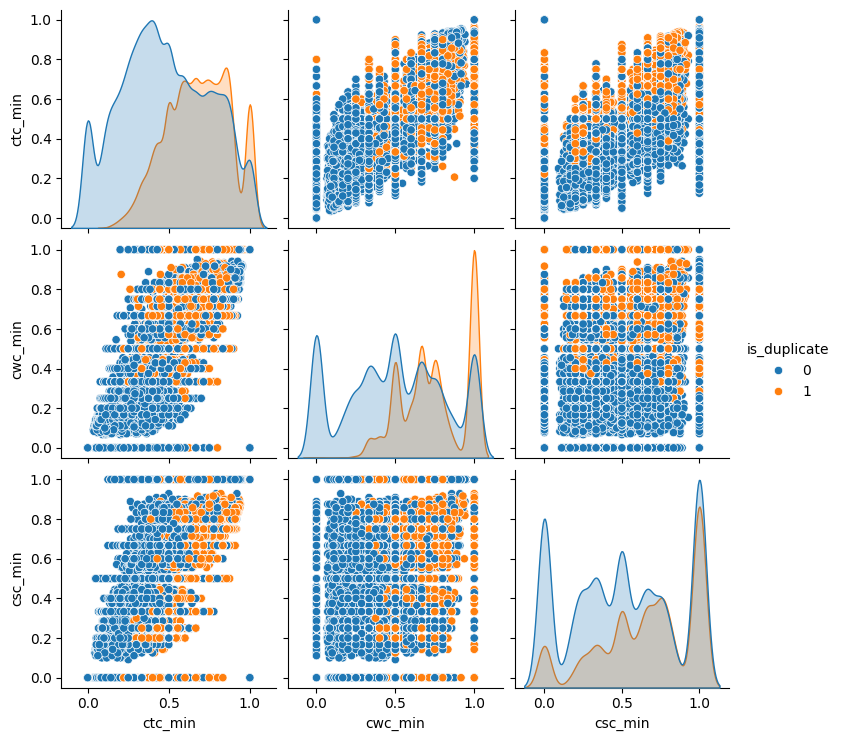

In [40]:
sns.pairplot(new_df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']],hue='is_duplicate')

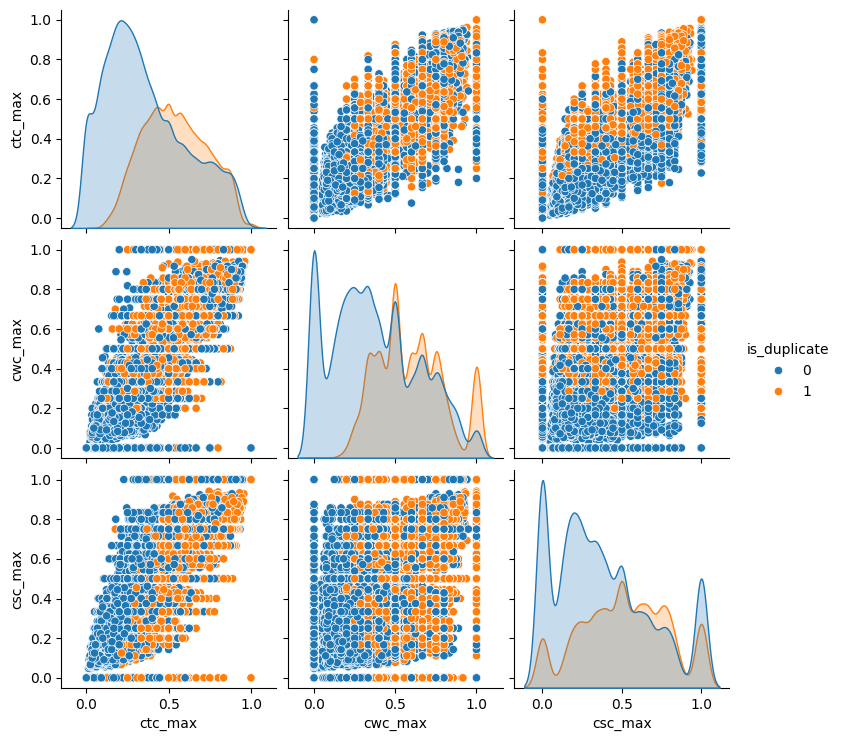

In [41]:
sns.pairplot(new_df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']],hue='is_duplicate')

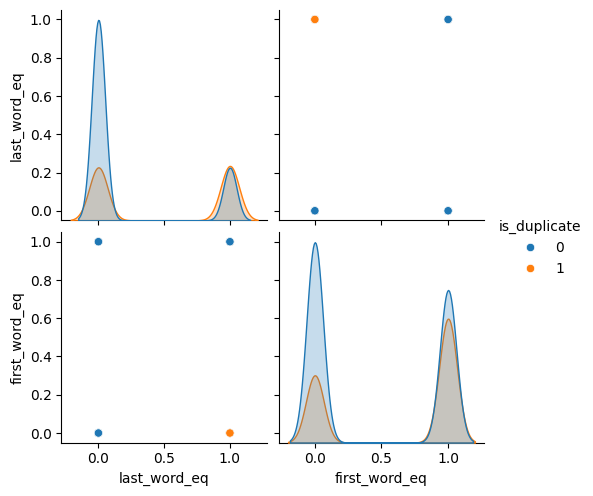

In [158]:
sns.pairplot(new_df[['last_word_eq', 'first_word_eq', 'is_duplicate']],hue='is_duplicate')

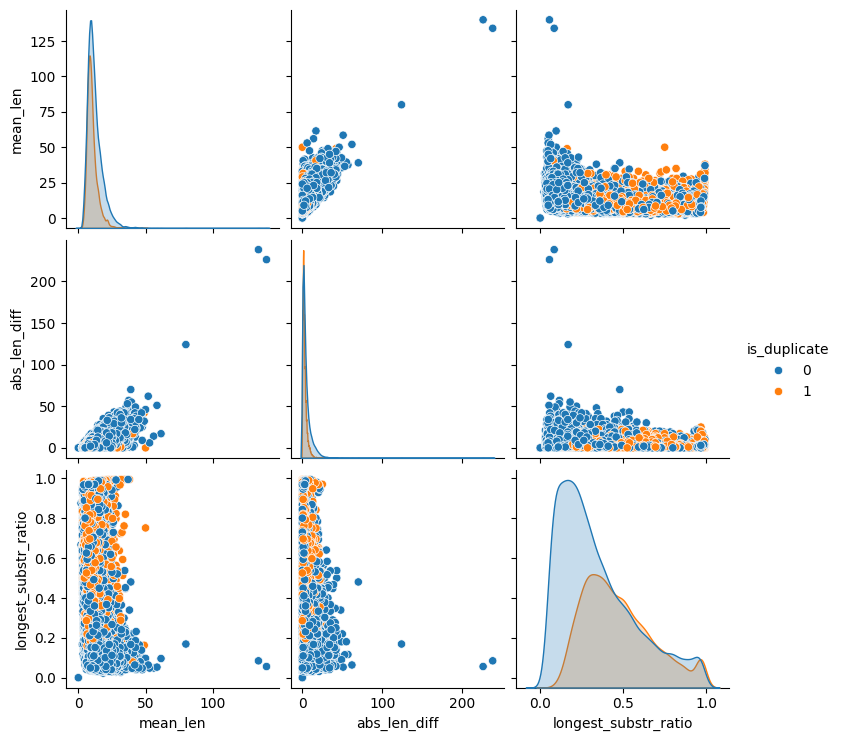

In [159]:
sns.pairplot(new_df[['mean_len', 'abs_len_diff','longest_substr_ratio', 'is_duplicate']],hue='is_duplicate')

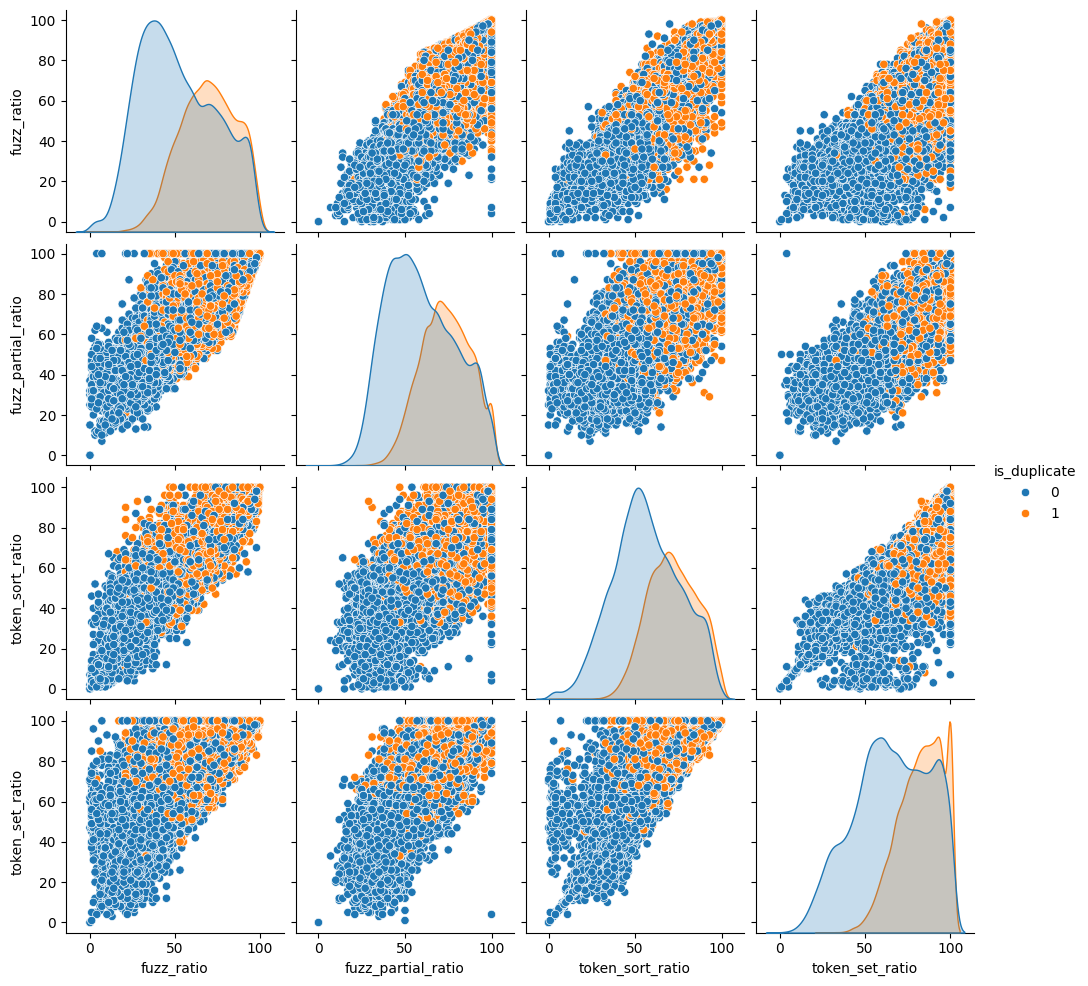

In [160]:
sns.pairplot(new_df[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],hue='is_duplicate')

In [161]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

X = MinMaxScaler().fit_transform(new_df[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = new_df['is_duplicate'].values

In [162]:
from sklearn.manifold import TSNE

tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.295s...
[t-SNE] Computed neighbors for 50000 samples in 22.044s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for sa

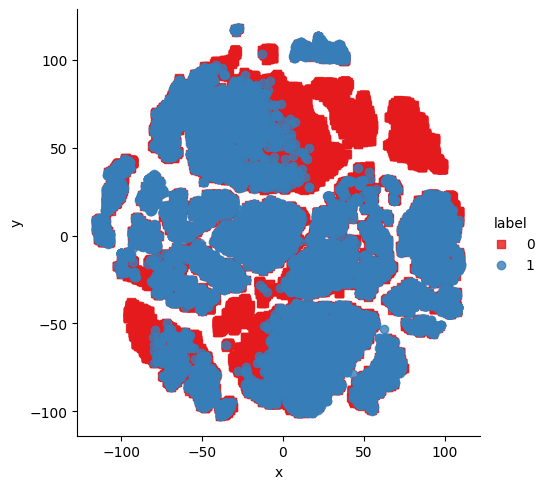

In [165]:
x_df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=x_df, x='x', y='y', hue='label', fit_reg=False,palette="Set1",markers=['s','o'])

## Make Model

In [44]:
ques_df = new_df[['question1','question2']]
ques_df.head()

,question1,question2
398782,what is the best marketing automation tool for...,what is the best marketing automation tool for...
115086,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...
327711,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...
367788,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...
151235,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy


In [45]:
final_df = new_df.drop(columns=['id','qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()

(50000, 23)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_word,total_word,word_share,cwc_min,cwc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
398782,1,75,76,13,13,12,26,0.46,0.874989,0.874989,...,0.923070,1,1,0.0,13.0,0.855263,99,99,99,99
115086,0,48,56,13,16,8,24,0.33,0.749981,0.599988,...,0.499997,1,1,3.0,13.5,0.224490,69,67,65,74
327711,0,104,119,28,21,4,38,0.11,0.099999,0.099999,...,0.142857,0,0,6.0,23.0,0.047619,26,29,34,43
367788,0,58,145,14,32,1,34,0.03,0.142855,0.076922,...,0.031250,0,0,17.0,21.5,0.050847,29,41,23,30
151235,0,34,49,5,9,3,13,0.23,0.749981,0.599988,...,0.333330,1,0,4.0,7.0,0.542857,55,70,48,69


## BOW

In [224]:
# apply BOW in ques_df

questions = list(ques_df['question1']) + list(ques_df['question2'])
cv = CountVectorizer(max_features=1000)

In [225]:
cv.fit_transform(questions).toarray().shape

(100000, 1000)

In [226]:
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [227]:
q1_arr.shape

(50000, 1000)

In [228]:
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(50000, 2000)

In [229]:
final_df = pd.concat([final_df, temp_df], axis=1)
print(final_df.shape)
final_df.head()

(50000, 2023)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_word,total_word,word_share,cwc_min,cwc_max,...,990,991,992,993,994,995,996,997,998,999
398782,1,75,76,13,13,12,26,0.46,0.874989,0.874989,...,0,0,0,0,0,0,0,0,0,0
115086,0,48,56,13,16,8,24,0.33,0.749981,0.599988,...,0,0,0,0,0,0,0,0,0,0
327711,0,104,119,28,21,4,38,0.11,0.099999,0.099999,...,0,0,0,0,0,0,0,0,0,0
367788,0,58,145,14,32,1,34,0.03,0.142855,0.076922,...,0,0,0,0,0,0,0,0,0,0
151235,0,34,49,5,9,3,13,0.23,0.749981,0.599988,...,0,0,0,0,0,0,0,0,0,0


In [230]:
X = final_df.iloc[:,1:].values
y = final_df.iloc[:,0].values
X.shape

(50000, 2022)

In [232]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [233]:
X_train.shape

(40000, 2022)

In [60]:
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

In [53]:
# XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred1 = xgb.predict(X_test)
accuracy_score(y_test,y_pred1)

0.7936

In [234]:
# RandomForestClassifier
rf_bw = RandomForestClassifier()
rf_bw.fit(X_train,y_train)
y_pred = rf_bw.predict(X_test)
accuracy_score(y_test,y_pred)

0.7917

In [ ]:
lg = LogisticRegression()
lg.fit(X_train, y_train)
y_pred3 = lg.predict(X_test)

accuracy_score(y_pred3, y_test)

In [ ]:
# for random forest model
confusion_matrix(y_test,y_pred)

In [ ]:
# for xgboost model
confusion_matrix(y_test,y_pred1)

In [ ]:
# for Logistic regression
confusion_matrix(y_test,y_pred3)

## TF-IDF

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [203]:
final_df = new_df.drop(columns=['id','qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()

(50000, 23)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_word,total_word,word_share,cwc_min,cwc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
398782,1,75,76,13,13,12,26,0.46,0.874989,0.874989,...,0.923070,1,1,0.0,13.0,0.855263,99,99,99,99
115086,0,48,56,13,16,8,24,0.33,0.749981,0.599988,...,0.499997,1,1,3.0,13.5,0.224490,69,67,65,74
327711,0,104,119,28,21,4,38,0.11,0.099999,0.099999,...,0.142857,0,0,6.0,23.0,0.047619,26,29,34,43
367788,0,58,145,14,32,1,34,0.03,0.142855,0.076922,...,0.031250,0,0,17.0,21.5,0.050847,29,41,23,30
151235,0,34,49,5,9,3,13,0.23,0.749981,0.599988,...,0.333330,1,0,4.0,7.0,0.542857,55,70,48,69


In [204]:
tf_idf = TfidfVectorizer(max_features=100)

In [205]:
questions = list(ques_df['question1']) + list(ques_df['question2'])

In [206]:
que_tf = tf_idf.fit_transform(questions).toarray()
que_tf.shape

(100000, 100)

In [207]:
q1_arr, q2_arr = np.vsplit(que_tf, 2)

In [208]:
q1_arr.shape

(50000, 100)

In [209]:
tem1 = pd.DataFrame(q1_arr, index=ques_df.index)
tem2 = pd.DataFrame(q2_arr, index=ques_df.index)
temp_df = pd.concat([tem1, tem2], axis =1 )
temp_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
398782,0.0,0.0,0.0,0.000000,0.0,0.447075,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
115086,0.0,0.0,0.0,0.477917,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
327711,0.0,0.0,0.0,0.356192,0.0,0.196660,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
367788,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
151235,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [210]:
tem1.iloc[0].value_counts()

398782
0.000000    94
0.447075     1
0.532198     1
0.479104     1
0.322960     1
0.305268     1
0.299762     1
Name: count, dtype: int64

In [211]:
final_df1 = pd.concat([final_df, temp_df], axis=1)
print(final_df1.shape)
final_df1.head()

(50000, 223)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_word,total_word,word_share,cwc_min,cwc_max,...,90,91,92,93,94,95,96,97,98,99
398782,1,75,76,13,13,12,26,0.46,0.874989,0.874989,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
115086,0,48,56,13,16,8,24,0.33,0.749981,0.599988,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
327711,0,104,119,28,21,4,38,0.11,0.099999,0.099999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
367788,0,58,145,14,32,1,34,0.03,0.142855,0.076922,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
151235,0,34,49,5,9,3,13,0.23,0.749981,0.599988,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [216]:
X = final_df1.iloc[:,1:].values
y = final_df1.iloc[:,0].values
X.shape

(50000, 222)

In [217]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [218]:
X_train.shape, X_test.shape

((40000, 222), (10000, 222))

In [219]:
# make model
# !pip install lightgbm
import lightgbm as lgb

In [220]:
xg_tf = XGBClassifier()
xg_tf.fit(X_train, y_train)
y_pred1 = xg_tf.predict(X_test)
accuracy_score(y_pred1, y_test)

0.7803

In [ ]:
lgb_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1)
lgb_model.fit(X_train, y_train)
y_pred2 = lgb_model.predict(X_test)
accuracy_score(y_pred2, y_test)

In [61]:
# for XG boost
confusion_matrix(y_test, y_pred1)

array([[5029, 1256],
       [1207, 2508]], dtype=int64)

In [ ]:
# for lightGBM
confusion_matrix(y_test, y_pred2)

## 3 Word2Vec

In [41]:
import gensim
from gensim.utils import simple_preprocess

In [42]:
final_df = new_df.drop(columns=['id','qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()

(50000, 23)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_word,total_word,word_share,cwc_min,cwc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
398782,1,75,76,13,13,12,26,0.46,0.874989,0.874989,...,0.923070,1,1,0.0,13.0,0.855263,99,99,99,99
115086,0,48,56,13,16,8,24,0.33,0.749981,0.599988,...,0.499997,1,1,3.0,13.5,0.224490,69,67,65,74
327711,0,104,119,28,21,4,38,0.11,0.099999,0.099999,...,0.142857,0,0,6.0,23.0,0.047619,26,29,34,43
367788,0,58,145,14,32,1,34,0.03,0.142855,0.076922,...,0.031250,0,0,17.0,21.5,0.050847,29,41,23,30
151235,0,34,49,5,9,3,13,0.23,0.749981,0.599988,...,0.333330,1,0,4.0,7.0,0.542857,55,70,48,69


In [46]:
questions = list((ques_df['question1'].apply(str.split))) + list((ques_df['question2'].apply(str.split)))
questions[0]

['what',
 'is',
 'the',
 'best',
 'marketing',
 'automation',
 'tool',
 'for',
 'small',
 'and',
 'mid',
 'size',
 'companies']

In [ ]:
# tokenized_story = [simple_preprocess(q) for q in questions] 

In [47]:
model = gensim.models.Word2Vec(
    sentences=questions, vector_size=300, window=5, min_count=2, workers=4
)

In [48]:
model.wv.index_to_key

['the',
 'what',
 'is',
 'i',
 'how',
 'a',
 'to',
 'in',
 'do',
 'of',
 'are',
 'and',
 'can',
 'for',
 'you',
 'why',
 'it',
 'my',
 'best',
 'on',
 'does',
 'have',
 'or',
 'if',
 'be',
 'which',
 'that',
 'some',
 'should',
 'get',
 'not',
 'with',
 'an',
 'from',
 'your',
 'india',
 'has',
 'will',
 's',
 'who',
 'when',
 'at',
 'people',
 'like',
 'would',
 'good',
 'there',
 'as',
 'about',
 'between',
 'most',
 'one',
 'we',
 'quora',
 'did',
 'make',
 'way',
 'where',
 'by',
 'was',
 'life',
 'any',
 'me',
 'they',
 'so',
 'after',
 'time',
 'money',
 'know',
 'this',
 'difference',
 'new',
 'learn',
 'am',
 'use',
 'someone',
 'their',
 'find',
 'many',
 'work',
 'much',
 'than',
 'think',
 'all',
 'indian',
 'more',
 'trump',
 'ever',
 'first',
 'out',
 'without',
 'but',
 'other',
 'better',
 'world',
 'become',
 'start',
 'year',
 'online',
 'want',
 '2',
 'mean',
 'could',
 'english',
 'up',
 'he',
 'us',
 'into',
 'm',
 'job',
 'take',
 'go',
 'feel',
 '1',
 'day',
 '201

In [49]:
# if we make model like above then we no need to do this 2 things
# model.build_vocab(tokenized_story)
# model.train(tokenized_story, total_examples=model.corpus_count, epochs=model.epochs)

In [50]:
np.mean(model.wv['this', 'is'], axis = 0)

array([ 0.8689895 ,  0.40346763,  0.31072775,  0.10591695,  0.52163935,
       -0.95827305, -0.1205247 ,  0.69020903, -0.43163043, -0.63778156,
        0.07440442, -0.20042998, -0.5235759 ,  0.5680959 ,  0.18237068,
       -0.0060037 , -0.62518096,  0.37357008, -0.6741413 , -0.5763762 ,
       -0.10248822,  0.49128324,  0.6980707 , -0.5148744 , -0.09345198,
        0.06184612, -0.3071998 ,  0.6138693 , -0.48108795, -0.26274702,
        0.11459856,  0.06628767,  0.39456436,  0.10025886, -0.76750463,
        1.0245464 , -0.02783051, -0.6261525 , -0.24648836,  0.08830662,
        0.3068546 ,  0.02231452,  0.51480603, -0.20734724,  0.76028347,
        0.51124007,  0.1590085 , -0.20832372, -0.6660514 , -0.4146607 ,
       -0.03782502,  0.10971603, -0.64450336, -0.804941  ,  0.39146903,
       -0.04847607,  0.03467226, -0.49288696, -0.21959609, -0.7074738 ,
       -0.30322954, -0.5361316 ,  0.26499718,  0.3677412 ,  0.3996188 ,
       -0.01645622,  0.13913059, -0.25912225,  0.82988226, -0.02

### Change into w2v

#### 1 method

In [51]:
# convert question
def word_to_vec(x):
    array = [word for word in x.split() if word in model.wv.index_to_key]
    # print(array)
    if(len(array)) == 0:
        return np.zeros(model.vector_size)
        
    return np.array(np.mean(model.wv[array], axis = 0))
    

In [52]:
q1_arr = np.vstack(ques_df.question1.apply(word_to_vec).values)
q2_arr = np.vstack(ques_df.question2.apply(word_to_vec).values)

In [53]:
q2_arr.shape

(50000, 300)

In [54]:
q1_arr

array([[-0.12879704,  0.02515781,  0.26109555, ..., -0.3338764 ,
         0.23202047,  0.0933356 ],
       [-0.27671802, -0.24420196, -0.17999087, ..., -0.47759759,
         0.03314572,  0.22809492],
       [-0.17285602,  0.04509124, -0.12883133, ..., -0.25283831,
         0.07826563,  0.06906351],
       ...,
       [-0.06778337, -0.22399454, -0.17744176, ..., -0.18076596,
         0.86381686, -0.23903115],
       [-0.06273837,  0.14370927,  0.08178824, ..., -0.27810687,
         0.37752986, -0.02342104],
       [ 0.05085364,  0.0048218 ,  0.33001551, ..., -0.12112682,
         0.4577108 ,  0.06516048]])

#### 2 Method

In [165]:
def document_vector(doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc.split() if word in model.wv.index_to_key]
    # print(doc)
    if len(doc) == 0:  # If no words exist in vocabulary, return zeros
        return np.zeros(model.vector_size)
         
    return (np.mean(model.wv[doc], axis=0))

In [166]:
np.array(document_vector('what is the best marketing automation tool for'))

array([-0.1908625 , -0.18988688,  0.17500743,  0.21590865,  0.03792908,
       -0.27598047,  0.10612658,  0.41473112,  0.11945014, -0.23359533,
       -0.211229  , -0.10228521, -0.15523797, -0.37213755,  0.04047019,
       -0.21643522,  0.193461  , -0.02424841, -0.08731563,  0.3026731 ,
        0.2384087 ,  0.29766622,  0.43480814, -0.32967162, -0.02191396,
       -0.04013759, -0.39075392,  0.1973699 ,  0.19667146, -0.16591917,
       -0.28019246,  0.05801961,  0.1047307 , -0.05887402,  0.00195214,
        0.54787207,  0.18181108, -0.36751094, -0.14065883,  0.37060508,
       -0.05933413,  0.48511422,  0.06684682, -0.34510905,  0.18386361,
        0.34198228, -0.07237122, -0.2963906 , -0.22020124,  0.26635444,
       -0.205105  , -0.33163443, -0.12386564, -0.0629123 , -0.34732932,
        0.11930716, -0.18159744, -0.2843279 ,  0.14248283, -0.19657305,
       -0.56683815, -0.04813989, -0.13525629,  0.21371636,  0.070437  ,
       -0.06053632, -0.27912456,  0.3178075 , -0.18104908, -0.05

In [186]:
from tqdm import tqdm

In [187]:
def make_w2v(que):
    X = []
    for doc in tqdm(que):
        X.append(document_vector(doc))
    return np.array(X)

In [188]:
q1_array = make_w2v(ques_df.question1.values)
# q2_array = make_w2v(ques_df.question2.values)


100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:13<00:00, 3807.46it/s]


In [189]:
q1_array

array([[-0.21257912, -0.03001185,  0.09030866, ..., -0.35036513,
         0.23154545,  0.05080735],
       [-0.3263424 ,  0.13189588, -0.47562578, ..., -0.47226796,
         0.07756032,  0.05501512],
       [-0.23011556,  0.2042585 , -0.29120094, ..., -0.15906096,
         0.02143602, -0.04184919],
       ...,
       [ 0.10102022,  0.07142563, -0.41671619, ...,  0.0479837 ,
         1.02402294, -0.27314207],
       [-0.10237052,  0.11038219,  0.00472268, ..., -0.29669857,
         0.37007913, -0.0358924 ],
       [ 0.12074663,  0.38046366,  0.23348297, ..., -0.11019017,
         0.62744915,  0.13213745]])

In [300]:
# make dataFrame

In [55]:
# temp_df1 = pd.DataFrame(q1_array, index= ques_df.index)
# temp_df2 = pd.DataFrame(q2_array, index= ques_df.index)

temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(50000, 600)

In [56]:
temp_df.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
398782,-0.128797,0.025158,0.261096,0.352025,-0.136905,-0.133258,0.138141,0.454655,0.049227,-0.171271,...,-0.102981,0.137560,0.405431,-0.318594,0.026653,0.090862,0.104882,-0.335939,0.243222,0.114904
115086,-0.276718,-0.244202,-0.179991,-0.129305,0.482624,-0.107285,-0.213274,-0.133347,0.090479,-0.664535,...,0.285845,-0.064601,0.563826,0.148333,0.107242,-0.059623,0.209772,-0.359821,0.088621,0.128121
327711,-0.172856,0.045091,-0.128831,-0.001532,0.405035,-0.037255,-0.125458,0.218862,0.093225,-0.391673,...,-0.015802,0.127095,0.477478,-0.056342,0.029118,-0.024670,0.204333,-0.306264,0.038006,-0.014282
367788,0.323817,0.126730,0.065734,-0.159452,-0.029903,-0.094792,0.359019,0.293285,-0.055080,-0.245894,...,0.218771,0.484879,0.832089,0.178174,0.240015,0.288196,-0.076796,0.019837,0.366139,-0.356269
151235,0.034439,0.328794,0.023585,0.021556,0.137931,-0.063345,0.384540,0.246946,-0.056209,-0.102735,...,0.083625,0.390548,0.365377,-0.096477,0.368222,0.389256,0.107281,-0.171384,0.336931,-0.464334


In [57]:
final_df = pd.concat([final_df, temp_df], axis=1)
print(final_df.shape)
final_df.head()

(50000, 623)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_word,total_word,word_share,cwc_min,cwc_max,...,290,291,292,293,294,295,296,297,298,299
398782,1,75,76,13,13,12,26,0.46,0.874989,0.874989,...,-0.102981,0.137560,0.405431,-0.318594,0.026653,0.090862,0.104882,-0.335939,0.243222,0.114904
115086,0,48,56,13,16,8,24,0.33,0.749981,0.599988,...,0.285845,-0.064601,0.563826,0.148333,0.107242,-0.059623,0.209772,-0.359821,0.088621,0.128121
327711,0,104,119,28,21,4,38,0.11,0.099999,0.099999,...,-0.015802,0.127095,0.477478,-0.056342,0.029118,-0.024670,0.204333,-0.306264,0.038006,-0.014282
367788,0,58,145,14,32,1,34,0.03,0.142855,0.076922,...,0.218771,0.484879,0.832089,0.178174,0.240015,0.288196,-0.076796,0.019837,0.366139,-0.356269
151235,0,34,49,5,9,3,13,0.23,0.749981,0.599988,...,0.083625,0.390548,0.365377,-0.096477,0.368222,0.389256,0.107281,-0.171384,0.336931,-0.464334


In [58]:
X = final_df.iloc[:,1:].values
y = final_df.iloc[:,0].values
X.shape

(50000, 622)

In [59]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [60]:
X_train.shape

(40000, 622)

In [209]:
# XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred1 = xgb.predict(X_test)
accuracy_score(y_test,y_pred1)

0.7901

In [61]:
# RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.7864

In [211]:
# for random forest model
confusion_matrix(y_test,y_pred)

array([[5336,  949],
       [1191, 2524]], dtype=int64)

In [212]:
# for random forest model
confusion_matrix(y_test,y_pred1)

array([[5306,  979],
       [1120, 2595]], dtype=int64)

In [214]:
lgb_model_w2v = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1)
lgb_model_w2v.fit(X_train, y_train)
y_pred3 = lgb_model_w2v.predict(X_test)
accuracy_score(y_test, y_pred3)

[LightGBM] [Info] Number of positive: 14684, number of negative: 25316
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 155590
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 622
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.367100 -> initscore=-0.544678
[LightGBM] [Info] Start training from score -0.544678


0.791

In [215]:
# for lgb model
confusion_matrix(y_test,y_pred3)

array([[5284, 1001],
       [1089, 2626]], dtype=int64)

## 4 Make LSTM Model

In [288]:
import tensorflow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, Input
from tensorflow.keras import mixed_precision
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [289]:
final_df = new_df.drop(columns=['id','qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()

(50000, 23)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_word,total_word,word_share,cwc_min,cwc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
398782,1,75,76,13,13,12,26,0.46,0.874989,0.874989,...,0.923070,1,1,0.0,13.0,0.855263,99,99,99,99
115086,0,48,56,13,16,8,24,0.33,0.749981,0.599988,...,0.499997,1,1,3.0,13.5,0.224490,69,67,65,74
327711,0,104,119,28,21,4,38,0.11,0.099999,0.099999,...,0.142857,0,0,6.0,23.0,0.047619,26,29,34,43
367788,0,58,145,14,32,1,34,0.03,0.142855,0.076922,...,0.031250,0,0,17.0,21.5,0.050847,29,41,23,30
151235,0,34,49,5,9,3,13,0.23,0.749981,0.599988,...,0.333330,1,0,4.0,7.0,0.542857,55,70,48,69


In [290]:
tokenizer = Tokenizer(num_words=5000 ,oov_token= '<oov_token>')
tokenizer.fit_on_texts(questions)

In [291]:
len(tokenizer.word_index)

33446

In [292]:
q1_a = tokenizer.texts_to_sequences(ques_df.question1)
q2_a = tokenizer.texts_to_sequences(ques_df.question2)

In [293]:
q1_a = pad_sequences(q1_a, maxlen = 50)
q2_a = pad_sequences(q2_a, maxlen = 50)

In [294]:
q1_a.shape, q2_a.shape

((50000, 50), (50000, 50))

In [295]:
array = final_df.iloc[:, 1:].values

In [296]:
array, array.shape

(array([[ 75.,  76.,  13., ...,  99.,  99.,  99.],
        [ 48.,  56.,  13., ...,  67.,  65.,  74.],
        [104., 119.,  28., ...,  29.,  34.,  43.],
        ...,
        [ 24.,  28.,   5., ...,  92.,  69.,  86.],
        [ 79.,  49.,  15., ...,  61.,  63.,  80.],
        [ 38.,  48.,   8., ...,  66.,  53.,  72.]]),
 (50000, 22))

In [297]:
X = np.concatenate([q1_a, q2_a, array], axis = 1)
y = final_df.iloc[:, 0].values

In [298]:
X.shape, y.shape

((50000, 122), (50000,))

In [299]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [300]:
X_train.shape, y_train.shape

((40000, 122), (40000,))

In [301]:
# make lstm

In [306]:
model = Sequential()
model.add(Embedding(input_dim=5001, output_dim=50))  
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [307]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_18 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [308]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [309]:
model.fit(X_train, y_train, batch_size=150, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
267/267 ━━━━━━━━━━━━━━━━━━━━ 143s 509ms/step - accuracy: 0.6724 - loss: 0.5787 - val_accuracy: 0.7457 - val_loss: 0.4719
Epoch 2/5
267/267 ━━━━━━━━━━━━━━━━━━━━ 131s 489ms/step - accuracy: 0.7756 - loss: 0.4453 - val_accuracy: 0.7597 - val_loss: 0.4605
Epoch 3/5
267/267 ━━━━━━━━━━━━━━━━━━━━ 149s 558ms/step - accuracy: 0.7991 - loss: 0.4169 - val_accuracy: 0.7630 - val_loss: 0.4556
Epoch 4/5
267/267 ━━━━━━━━━━━━━━━━━━━━ 181s 679ms/step - accuracy: 0.8080 - loss: 0.4004 - val_accuracy: 0.7614 - val_loss: 0.4506
Epoch 5/5
267/267 ━━━━━━━━━━━━━━━━━━━━ 279s 970ms/step - accuracy: 0.8185 - loss: 0.3795 - val_accuracy: 0.7607 - val_loss: 0.4602


In [ ]:
# for testing

In [67]:
def test_common_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return len(w1 & w2)

In [68]:
def test_total_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return (len(w1) + len(w2))

In [69]:
contractions

{"ain't": 'am not / are not / is not / has not / have not',
 "aren't": 'are not / am not',
 "can't": 'cannot',
 "can't've": 'cannot have',
 "'cause": 'because',
 "could've": 'could have',
 "couldn't": 'could not',
 "couldn't've": 'could not have',
 "didn't": 'did not',
 "doesn't": 'does not',
 "don't": 'do not',
 "hadn't": 'had not',
 "hadn't've": 'had not have',
 "hasn't": 'has not',
 "haven't": 'have not',
 "he'd": 'he had / he would',
 "he'd've": 'he would have',
 "he'll": 'he shall / he will',
 "he'll've": 'he shall have / he will have',
 "he's": 'he has / he is',
 "how'd": 'how did',
 "how'd'y": 'how do you',
 "how'll": 'how will',
 "how's": 'how has / how is / how does',
 "I'd": 'I had / I would',
 "I'd've": 'I would have',
 "I'll": 'I shall / I will',
 "I'll've": 'I shall have / I will have',
 "I'm": 'I am',
 "I've": 'I have',
 "isn't": 'is not',
 "it'd": 'it had / it would',
 "it'd've": 'it would have',
 "it'll": 'it shall / it will',
 "it'll've": 'it shall have / it will have'

In [70]:
def preprocess(q):
    # Make into the lower case
    q = q.lower().strip()

    # Remove Html tag
    q = BeautifulSoup(q)
    q = q.get_text()

    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')

    
     # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)


    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")

    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    return q

In [71]:
# for create 22 features

def test_fetch_token_features(q1,q2):
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

In [72]:
def test_fetch_length_features(q1,q2):
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features

In [73]:
def test_fetch_fuzzy_features(q1,q2):
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [74]:
def query_point_creator_bag_of_word(q1,q2):
    
    input_query = []
    
    # preprocess
    q1 = preprocess(q1)
    q2 = preprocess(q2)
    
    # fetch basic features
    input_query.append(len(q1))
    input_query.append(len(q2))
    
    input_query.append(len(q1.split(" ")))
    input_query.append(len(q2.split(" ")))
    
    input_query.append(test_common_words(q1,q2))
    input_query.append(test_total_words(q1,q2))
    input_query.append(round(test_common_words(q1,q2)/test_total_words(q1,q2),2))
    
    # fetch token features
    token_features = test_fetch_token_features(q1,q2)
    input_query.extend(token_features)
    
    # fetch length based features
    length_features = test_fetch_length_features(q1,q2)
    input_query.extend(length_features)
    
    # fetch fuzzy features
    fuzzy_features = test_fetch_fuzzy_features(q1,q2)
    input_query.extend(fuzzy_features)
    
    # bow feature for q1
    q1_bow = cv.transform([q1]).toarray()
    print(q1_bow.shape)
    
    # bow feature for q2
    q2_bow = cv.transform([q2]).toarray()
    print(q2_bow.shape)
    
    return np.hstack((np.array(input_query).reshape(1,22),q1_bow,q2_bow))

In [65]:
q1 = 'Where is the capital of India?'
q2 = 'What is the capital of Pakistan?'
q3 = 'Which city serves as the capital of India?'
q4 = 'who i am'

## 1 BOW

In [236]:
query_point_creator_bag_of_word(q1,q2).shape

(1, 1000)
(1, 1000)


(1, 2022)

In [237]:
rf_bw.predict(query_point_creator_bag_of_word(q1,q4))

(1, 1000)
(1, 1000)


array([0], dtype=int64)

In [238]:
import pickle

pickle.dump(rf_bw,open('bagofword.pkl','wb'))
pickle.dump(cv,open('cv_bow.pkl','wb'))

## 3 w2v

In [161]:
q1.split()

['Where', 'is', 'the', 'capital', 'of', 'India?']

In [62]:
def sentence_vector(sentence, model):
    words = sentence.split()
    vectors = [model.wv[word] for word in words if word in model.wv]  # Ignore OOV words
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)  # Return zero vector if all words are OOV

In [63]:
def query_point_creator_w2v(q1,q2):
    
    input_query = []
    
    # preprocess
    q1 = preprocess(q1)
    q2 = preprocess(q2)
    
    # fetch basic features
    input_query.append(len(q1))
    input_query.append(len(q2))
    
    input_query.append(len(q1.split(" ")))
    input_query.append(len(q2.split(" ")))
    
    input_query.append(test_common_words(q1,q2))
    input_query.append(test_total_words(q1,q2))
    input_query.append(round(test_common_words(q1,q2)/test_total_words(q1,q2),2))
    
    # fetch token features
    token_features = test_fetch_token_features(q1,q2)
    input_query.extend(token_features)
    
    # fetch length based features
    length_features = test_fetch_length_features(q1,q2)
    input_query.extend(length_features)
    
    # fetch fuzzy features
    fuzzy_features = test_fetch_fuzzy_features(q1,q2)
    input_query.extend(fuzzy_features)
    
    # bow feature for q1
    q1_wv = sentence_vector(q1, model).reshape(1, 300)
    print(q1_wv.shape)
    # bow feature for q2
    q2_wv = sentence_vector(q2, model).reshape(1, 300)
    print(q2_wv.shape)
    
    return np.hstack((np.array(input_query).reshape(1,22),q1_wv,q2_wv))

In [75]:
query_point_creator_w2v(q1,q4).shape

(1, 300)
(1, 300)


(1, 622)

In [200]:
query_point_creator_w2v(q1,q4).shape

(1, 300)
(1, 300)


(1, 622)

In [199]:
rf.predict(query_point_creator_w2v(q1,q4))

(1, 300)
(1, 300)


array([0], dtype=int64)

In [203]:
pickle.dump(rf, open('wtov.pkl', 'wb'))
pickle.dump(model, open('model_wtov.pkl', 'wb'))

## TF-IDF

In [197]:
def query_point_creator_ifidf(q1,q2):
    
    input_query = []
    
    # preprocess
    q1 = preprocess(q1)
    q2 = preprocess(q2)
    
    # fetch basic features
    input_query.append(len(q1))
    input_query.append(len(q2))
    
    input_query.append(len(q1.split(" ")))
    input_query.append(len(q2.split(" ")))
    
    input_query.append(test_common_words(q1,q2))
    input_query.append(test_total_words(q1,q2))
    input_query.append(round(test_common_words(q1,q2)/test_total_words(q1,q2),2))
    
    # fetch token features
    token_features = test_fetch_token_features(q1,q2)
    input_query.extend(token_features)
    
    # fetch length based features
    length_features = test_fetch_length_features(q1,q2)
    input_query.extend(length_features)
    
    # fetch fuzzy features
    fuzzy_features = test_fetch_fuzzy_features(q1,q2)
    input_query.extend(fuzzy_features)
    
    # bow feature for q1
    q1_idf = tf_idf.transform([q1]).toarray()
    # print(q1_idf.shape)
    
    # bow feature for q2
    q2_idf = tf_idf.transform([q2]).toarray()
    # print(q2_idf.shape)

    other = np.array(input_query).reshape(1,22)
    # print(other.shape)
    
    return np.hstack((other, q1_idf, q2_idf))

In [198]:
query_point_creator_ifidf(q1,q4).shape

(1, 222)

In [221]:
xg_tf.predict(query_point_creator_ifidf(q1,q4))

array([0])

In [254]:
pickle.dump(xg_tf,open('xg_tf_idf.pkl','wb'))
pickle.dump(tf_idf,open('tf_idf.pkl','wb'))

## LSTM

In [310]:
def query_point_creator_LSTM(q1,q2):
    
    input_query = []
    
    # preprocess
    q1 = preprocess(q1)
    q2 = preprocess(q2)
    
    # fetch basic features
    input_query.append(len(q1))
    input_query.append(len(q2))
    
    input_query.append(len(q1.split(" ")))
    input_query.append(len(q2.split(" ")))
    
    input_query.append(test_common_words(q1,q2))
    input_query.append(test_total_words(q1,q2))
    input_query.append(round(test_common_words(q1,q2)/test_total_words(q1,q2),2))
    
    # fetch token features
    token_features = test_fetch_token_features(q1,q2)
    input_query.extend(token_features)
    
    # fetch length based features
    length_features = test_fetch_length_features(q1,q2)
    input_query.extend(length_features)
    
    # fetch fuzzy features
    fuzzy_features = test_fetch_fuzzy_features(q1,q2)
    input_query.extend(fuzzy_features)
    
    # bow feature for q1
    q1_lstm = tokenizer.texts_to_sequences([q1])
    q1_lstm = pad_sequences(q1_lstm, maxlen=50)
    print(q1_lstm.shape)
    
    # bow feature for q2
    q2_lstm = tokenizer.texts_to_sequences([q2])
    q2_lstm = pad_sequences(q2_lstm, maxlen=50)
    print(q2_lstm.shape)

    other = np.array(input_query).reshape(1,22)
    print(other.shape)
    
    return np.hstack((other, q1_lstm, q2_lstm))

In [311]:
query_point_creator_LSTM(q1,q4).shape

(1, 50)
(1, 50)
(1, 22)


(1, 122)

In [312]:
model.predict(query_point_creator_LSTM(q1,q4))

(1, 50)
(1, 50)
(1, 22)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[0.3083]], dtype=float16)

In [313]:
pickle.dump(model,open('model_lstm.pkl','wb'))
pickle.dump(tokenizer,open('tokenizer_lstm.pkl','wb'))